In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import poisson, norm
from scipy.optimize import minimize
import numpy as np

def poisson_val(n,lam):
    #use continuous gaussian approx, b/c asimov data may not be integer
    return norm.pdf(n, loc = lam, scale = math.sqrt(lam))

def expected_counts(pars,s,constants):
    poi = pars[0]
    nuisance_pars = pars[1:]
    
    signal_counts     = s(poi)
    background_counts = nuisance_pars
    tau_constants     = constants
        
    expected_actual = []
    expected_constraints = []
    
        
    for s,b,tau in zip(signal_counts, background_counts, tau_constants):
        expected_actual.append(s+b)
        expected_constraints.append(tau*b)

    expected = expected_actual + expected_constraints
    return expected

def model_pdf(pars, data, s, constants):
    lambdas = expected_counts(pars,s,constants)
    product = 1
    for data_bin, lambda_bin in zip(data, lambdas):
        product = product * poisson_val(data_bin, lambda_bin)
    return product

def generate_asimov_data(asimov_mu,data,constants,s, init_pars,par_bounds):
    bestfit_nuisance_asimov = constrained_bestfit(asimov_mu,data,constants,s, init_pars,par_bounds)
    return expected_counts(bestfit_nuisance_asimov,s,constants)

##########################

def loglambdav(pars, data, constants, s):
    poi = pars[0]
    nuisance_pars = pars[1:]
    return -2*np.log(model_pdf(pars, data, s, constants))


### The Test Statistic
def qmu(mu,data,constants,s, init_pars,par_bounds):
    mubhathat = constrained_bestfit(mu,data,constants,s, init_pars,par_bounds)
    muhatbhat = unconstrained_bestfit(data,constants,s, init_pars,par_bounds)
    qmu = loglambdav(mubhathat, data, constants,s)-loglambdav(muhatbhat, data, constants,s)
    if muhatbhat[0] > mu:
        return 0.0
    if -1e-6 < qmu <0:
        print 'WARNING: qmu negative: ', qmu
        return 0.0
    return qmu

### The Global Fit
def unconstrained_bestfit(data, constants,s, init_pars,par_bounds):
    result = minimize(loglambdav, init_pars, method='SLSQP', args = (data,constants,s), bounds = par_bounds)
    try:
        assert result.success
    except AssertionError:
        print result
    return result.x

### The Fit Conditions on a specific POI value
def constrained_bestfit(constrained_mu,data, constants,s, init_pars,par_bounds):
    cons = {'type': 'eq', 'fun': lambda v: v[0]-constrained_mu}
    result = minimize(loglambdav, init_pars, constraints=cons, method='SLSQP',args = (data,constants,s), bounds = par_bounds)
    try:
        assert result.success
    except AssertionError:
        print result
    return result.x
    
def pvals_from_teststat(sqrtqmu_v,sqrtqmuA_v):
    CLsb = 1-norm.cdf(sqrtqmu_v )
    CLb  = norm.cdf(sqrtqmuA_v-sqrtqmu_v)
    CLs  = CLb/CLsb
    return CLsb,CLb,CLs

def runOnePoint(muTest, data,constants,s,init_pars,par_bounds):
    asimov_mu = 0.0
    asimov_data = generate_asimov_data(asimov_mu,data,constants,s,init_pars,par_bounds)

    qmu_v  = qmu(muTest,data, constants,s, init_pars,par_bounds)
    qmuA_v = qmu(muTest,asimov_data, constants,s,init_pars,par_bounds)
    sqrtqmu_v = math.sqrt(qmu_v)
    sqrtqmuA_v = math.sqrt(qmuA_v)
    
    sigma = muTest/sqrtqmuA_v if sqrtqmuA_v > 0 else None

    CLsb,CLb,CLs = pvals_from_teststat(sqrtqmu_v, sqrtqmuA_v)
    
    CLs_exp = []
    for nsigma in [-2,-1,0,1,2]:
        sqrtqmu_v_sigma =  sqrtqmuA_v-nsigma 
        CLs_exp.append(pvals_from_teststat(sqrtqmu_v_sigma,sqrtqmuA_v)[-1])
    return qmu_v,qmuA_v,sigma,CLsb,CLb,CLs,CLs_exp

def runOnePoint_nbdelta(muTest, observed_counts,backgrounds_incl_uncert,nominal_signals, init_pars,par_bounds):
    constants = []
    actual_data = []
    constraint_data = []
    
    for n, b_incl_uncert, snom in zip(observed_counts,backgrounds_incl_uncert,nominal_signals):
        b, deltab = b_incl_uncert
        tau = b/deltab/deltab
        actual_data.append(n)
        constraint_data.append(tau*b)
        constants.append(tau)

    data = actual_data + constraint_data
    
    s = lambda mu: [mu*snom for snom in nominal_signals]  # signal_counts as function of signal strength
    return runOnePoint(muTest, data,constants,s,init_pars,par_bounds)    

In [3]:
def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross

In [4]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)


ON MU=1
CLs: obs 0.00521188078504 exp: [6.430963503387318e-05, 0.00074682514278028456, 0.0074520043681136627, 0.055714377575372703, 0.25534867031149289]
RUN SCAN


/Library/Python/2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: divide by zero encountered in double_scalars


{'exp': [0.4309309979961827,
  0.5605303824363357,
  0.7470123756919155,
  1.0233046284116467,
  1.3493988720818066],
 'obs': 0.7175112926172658}

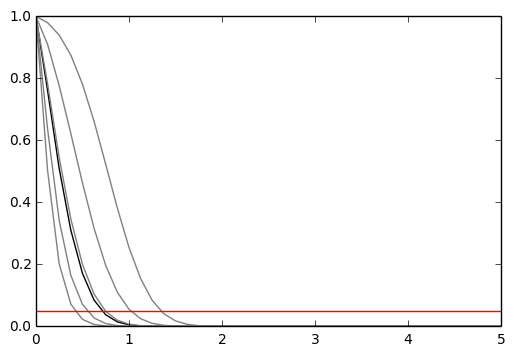

In [5]:
source = {
  "binning": [2,-0.5,1.5],
  "bindata": {
    "data":    [100.0, 145.0],
    "bkg":     [100.0, 150.0],
    "bkgerr":  [15.0, 20.0],
    "sig":     [30.0, 45.0]
  }
}
# import json
# source = json.load(open('./data/source.json'))


my_observed_counts = source['bindata']['data']
my_background_counts = zip(source['bindata']['bkg'],source['bindata']['bkgerr'])
my_signal_counts = source['bindata']['sig']
init_pars = [1.0] + [b[0] for b in my_background_counts]
par_bounds = [[0,10]] + [[0.5*b,2.*b] for b,db in my_background_counts]

# print my_observed_counts
# print my_background_counts
# print my_signal_counts
# print init_pars
# print par_bounds
# runOnePoint_nbdelta(1.0,my_observed_counts,my_background_counds,my_signal_counts,init_pars,par_bounds)


print 'ON MU=1'
d = runOnePoint_nbdelta(1.0,my_observed_counts,my_background_counts,my_signal_counts,init_pars,par_bounds)
print 'CLs: obs {} exp: {}'.format(1./d[-2],[1./x for x in d[-1]])

print 'RUN SCAN'


mutests = np.linspace(0,5,41)
tests = [runOnePoint_nbdelta(muTest,my_observed_counts,my_background_counts,my_signal_counts,init_pars,par_bounds) for muTest in mutests]
cls_obs = [1./test[-2]  for test in tests]
cls_exp = [[1./(test[-1][i])  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)

invert_interval(mutests, cls_obs, cls_exp)